# Choosing the learning paradigm

```{warning}
To run this Notebook, you will need access to at least one GPU. The results that are printed were obtained using a single A100 graphic card with 80 GB of memory. Note that even using such a powerful GPU took the notebook more than 10 hours to complete.
```

This book aims to illustrate with a practical example how to decide which learning paradigm is better for each application. To demonstrate the process, we will extract some information about chemical reactions from paragraphs of text.

## First steps

Choosing the learning paradigm should begin by trying some leading general-purpose LLM. For this practical case, the first model to test is the recent Llama-3 8B model with zero and one-shot prompts.

We will start by importing all the packages needed.

In [2]:
import json
from dotenv import load_dotenv

import torch
from datasets import (
    load_dataset,
    Dataset,
)
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from transformers.pipelines.pt_utils import KeyDataset
from peft import (
    LoraConfig,
)
from trl import (
    SFTTrainer,
    DataCollatorForCompletionOnlyLM,
)
from evaluate import load
# import litellm
# from litellm import completion
# from litellm.caching import Cache
from statistics import mean
import numpy as np 
import matplotlib.pyplot as plt 
import llmstructdata

To continue, we will allow `LiteLLM` to cache requests made to LLM-APIs. Additionally, we will import all environment variables.

```{margin}
Note that using the environment variables is the safest way of keeping personal API keys secret.
```

## First model and dataset

```{margin}
Groq provides some of the most popular open-source models, such as Llama or Mixtral models, with a high inference speed. To use the Groq API, the `.env` file must also contain the `GROQ_API_KEY`.
```

As starting model, we will try the Llama-3 8B model. We will call this model through the Groq API, which allows performing fast inference with several open-source models.

In [5]:
base_model = "groq/llama3-8b-8192"

```{margin}
**ORD** stands for Open Reaction Database, a comprehensive data structure specially designed to describe all the elements involved in chemical reactions.
```

The dataset used in this tutorial is the one used in {cite:t}`Ai_2024` recent work, which contains data about chemical reactions extracted by text-mined from United States patents. The dataset, the so-called [USPTO-ORD-100K dataset](https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873), contains 100K reaction procedure ORD-JSON pairs. 

```{admonition} Download data
:class: tip, dropdown

The best way to obtain the data is to install the GitHub repository of the Ai et al. work and take it from there. To do so, run the following commands: 

        !git clone https://github.com/qai222/LLM_organic_synthesis.git \
        !cp LLM_organic_synthesis/workplace_data/datasets/USPTO-n100k-t2048_exp1.7z .\
        !7za x USPTO-n100k-t2048_exp1.7z\
        !cp USPTO-n100k-t2048_exp1/*.json .\
        !rm -rf USPTO-n100k-t2048_exp1/ USPTO-n100k-t2048_exp1.7z LLM_organic_synthesis\

This will leave four `.json` files in your current directory that contain all the data used here.
```

```{margin}
Note that we only selected 100 samples from the test set. This will be enough for the demo shown here.
```

In [6]:
test_ds_path = "test.json"
test_dataset = load_dataset("json", data_files=test_ds_path, split="train")
test_dataset = test_dataset.shuffle(seed=42).select(range(100))
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 100
})

```{margin}
Note that the output comes in JSON format. For this simple example, we will not constrain the output to JSON format. However, to ensure good results, this constraining must be done. The chapter ["Constrained decoding and enforcing valid outputs"] (./file-you-link-to.qmd) provides explanations and examples about the options and how to constrain the output.
```

In [7]:
test_dataset[0]

{'instruction': 'Below is a description of an organic reaction. Extract information from it to an ORD JSON record.\n\n### Procedure:\nThe procedure of Example 1a) was repeated, except that 743 mg of 4-nitrobenzyl (1R,3R,5R,6S)-6-((1R)-1-hydroxyethyl)-1-methyl-2-oxo-1-carbapenam-3-carboxylate and 1.06 g 2-(tri-n-butylstannyl)-7-trifluoromethylthioimidazo[5,1-b]thiazole were used as the starting compounds. Thus, 172 mg of 4-nitrobenzyl (1S,5R,6S)-6-((1R)-1-hydroxyethyl)-1-methyl-2-(7-trifluoromethylthioimidazo[5,1-b]thiazol-2-yl)-1-carbapen-2-em-3-carboxylate was prepared.\n\n### ORD JSON:\n',
 'output': '{"inputs": {"m1": {"components": [{"identifiers": [{"type": "NAME", "value": "4-nitrobenzyl (1R,3R,5R,6S)-6-((1R)-1-hydroxyethyl)-1-methyl-2-oxo-1-carbapenam-3-carboxylate"}], "amount": {"mass": {"value": 743.0, "units": "MILLIGRAM"}}, "reaction_role": "REACTANT"}]}, "m2": {"components": [{"identifiers": [{"type": "NAME", "value": "2-(tri-n-butylstannyl)-7-trifluoromethylthioimidazo[5,1

This dataset is very big. Therefore, we will only take 100 samples from the test set used in the article mentioned above for our test set.

## Prompt and Inference

We define a simple prompt template. The prompt contains a simple system part (named **PREFIX**) where the role and task of the model are defined, as well as the example used only for the one-shot prompt. Additionally, the prompt has a *user* prompt where the reaction instruction will be provided.

```{margin}
**PREFIX** is supposed to be the content of the system prompt.
**SUFFIX** is the user prompt.
**SHOT** is the 1-shot prompt that will be added to the system prompt when used.
```

In [8]:
PREFIX = """You are a helpful scientific assistant. Your task is to extract information about organic reactions. {shot}"""
SUFFIX = """\n\n{sample}\n\n"""
SHOT = """
One example is provided to you to show how to perform the task:

### Procedure:\nA suspension of 8 g of the product of Example 7 and 0.4 g of DABCO in 90 ml of xylenes were heated under N2 at 130\u00b0-135\u00b0 C. while 1.8 ml of phosgene was added portionwise at a rate to maintain a reflux temperature of about 130\u00b0-135\u00b0 C. The mixture was refluxed an additional two hours, cooled under N2 to room temperature, filtered, and the filtrate was concentrated in vacuo to yield 6.9 g of the subject compound as a crude oil.\n\n
### ORD JSON:\n{\"inputs\": {\"m1_m2_m4\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"product\"}], \"amount\": {\"mass\": {\"value\": 8.0, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"DABCO\"}], \"amount\": {\"mass\": {\"value\": 0.4, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"xylenes\"}], \"amount\": {\"volume\": {\"value\": 90.0, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"SOLVENT\"}]}, \"m3\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"phosgene\"}], \"amount\": {\"volume\": {\"value\": 1.8, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"REACTANT\"}]}}, \"conditions\": {\"temperature\": {\"control\": {\"type\": \"AMBIENT\"}}, \"conditions_are_dynamic\": true}, \"workups\": [{\"type\": \"ADDITION\", \"details\": \"was added portionwise at a rate\"}, {\"type\": \"TEMPERATURE\", \"details\": \"to maintain a reflux temperature of about 130\\u00b0-135\\u00b0 C\"}, {\"type\": \"TEMPERATURE\", \"details\": \"The mixture was refluxed an additional two hours\", \"duration\": {\"value\": 2.0, \"units\": \"HOUR\"}}, {\"type\": \"FILTRATION\", \"details\": \"filtered\"}, {\"type\": \"CONCENTRATION\", \"details\": \"the filtrate was concentrated in vacuo\"}], \"outcomes\": [{\"products\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"subject compound\"}], \"measurements\": [{\"type\": \"AMOUNT\", \"details\": \"MASS\", \"amount\": {\"mass\": {\"value\": 6.9, \"units\": \"GRAM\"}}}], \"reaction_role\": \"PRODUCT\"}]}]}
\n
"""

To continue, we loop all over the dataset two times, one for each type of prompt (zero- and one-shot). For each dataset sample, we format the prompt to include the procedure-output schema pairs using the template defined in the previous cell. In addition, we also predict using the model and store those predictions for future evaluation.

```{margin}
The beauty of `LiteLLM` is that it allows obtaining completions from models by different providers using the [OpenAI prompt completions' schema](https://platform.openai.com/docs/api-reference/chat/create) for all providers:

`{"role": "system", "content": system_message},
{"role": "user", "content": user_message}`
```

shots = ["0-shot", "1-shot"]
results_llama = {}

# Start by looping over the shots
for s in shots:
    predictions = []
    references = []

    # Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        # Format the prompt
        if s == "0-shot":
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        # Do the completion using Groq API through LiteLLM
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )
        # Save the predictions and the references for later evaluation
        references.append(output)
        predictions.append(pred)

    results_llama[s] = {
        "predictions": predictions,
        "references": references,
    }

After generating the predictions, it's essential to evaluate them. We will initially use the BERTScore for a simple evaluation, as it provides precision, recall, and F$_1$ scores based on similarity measures. However, for a complex schema like the one we are predicting, more robust evaluation methods should be utilized. (REF EVALUATION CHAPTER)


```{admonition}  Notes about BERTScore
:class: tip, dropdown
BERTScore {cite}`zhang2020bertscore` is an evaluation method that proceeds by calculating the similarity of the candidate text with the reference. This similarity is calculated as a sum of cosine similarities token by token. To produce the embeddings this similarity calculation, in the original article, they used the BERT model's embeddings. However, for our case we will be using the embeddings from the DistilBERT model {cite}`sanh2020distilbert` which achieves 97% of the original BERT model language understanding while only being 40% the size of BERT original model.
```

bertscore = load("bertscore")
shots = ["0-shot", "1-shot"]

# Start by looping over the shots
for s in shots:
    predictions = results_llama[s]["predictions"]
    references = results_llama[s]["references"]

    results_ = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="distilbert-base-uncased",
    )

    results_llama[s].update(
        {
            "precision": mean(results_["precision"]),
            "recall": mean(results_["recall"]),
            "f1_scores": mean(results_["f1"]),
        }
    )

In [10]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {round(results_llama[s]["precision"], 4)}")
    print(f"\tRecall: {round(results_llama[s]["recall"], 4)}")
    print(f"\tF1-Score: {round(results_llama[s]["f1_scores"], 4)}\n")

Results for the 0-shot prompt
	Precision: 0.865
	Recall: 0.8918
	F1-Score: 0.8781

Results for the 1-shot prompt
	Precision: 0.9392
	Recall: 0.9553
	F1-Score: 0.9471



The results are excellent, especially with the one-shot prompt. However, we are going to try a different model, a closed-source model, to compare.

In [11]:
# Remember to save the results for future evaluation!
with open("Llama_results.json", "w") as f:
    json.dump(results_llama, f, indent=4)

## Another model, closed-source this time

The second model we will use is the newer OpenAI, GPT-4o. Doing this allows us to compare open- and closed-source models.

The procedure and code are exactly the same as for the previous case; the only difference is to define a different model.

```{margin}
OpenAI models are also supported by the `LiteLLM` package.
```

In [12]:
base_model = "gpt-4o"

And we obtain the completions using both prompts for all the test samples.

results_openai = {}
shots = ["0-shot", "1-shot"]

# Start by looping over the shots
for s in shots:
    predictions = []
    references = []

    # Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        # Format the prompt following OpenAI's prompting guidelines
        if s == "0-shot":
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        # Do the completion using Groq API through LiteLLM
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )
        # Remove some residual stuff in the json output by the model.
        if "```json" in pred:
            pred = pred.replace("```json\n", "")
            pred = pred.replace("```", "")

        # Save the predictions and the references for later evaluation
        references.append(output)
        predictions.append(pred)

    results_openai[s] = {
        "predictions": predictions,
        "references": references,
    }

Finally, we evaluate again using BERTScore. 

for s in shots:
    predictions = results_openai[s]["predictions"]
    references = results_openai[s]["references"]

    results_ = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="distilbert-base-uncased",
    )

    results_openai[s].update(
        {
            "precision": mean(results_["precision"]),
            "recall": mean(results_["recall"]),
            "f1_scores": mean(results_["f1"]),
        }
    )

In [14]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {round(results_openai[s]['precision'], 4)}")
    print(f"\tRecall: {round(results_openai[s]['recall'], 4)}")
    print(f"\tF1-Score: {round(results_openai[s]['f1_scores'], 4)}\n")

Results for the 0-shot prompt
	Precision: 0.8949
	Recall: 0.9093
	F1-Score: 0.9019

Results for the 1-shot prompt
	Precision: 0.9545
	Recall: 0.9619
	F1-Score: 0.9581



The results with this GPT-4o model are excellent, improving slightly on the ones obtained with the Llama-3 8B base model. However, we are going to try to improve these results further by fine-tuning the Llama-3 8B model.

In [15]:
# Remember to safe the results for future evaluation!
with open("OpenAI_results.json", "w") as f:
    json.dump(results_openai, f, indent=4)

## Fine-tuning

As the final step, we will fine-tune the Llama-3 8B using data similar to the one we used above.

We will use packages built by [HuggingFace](https://huggingface.co/) to do the fine-tuning.

First, we define the base model we will use and the path of the dataset. 

In [16]:
# Model
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

```{caution}
It is important to include the `HF_token` in the `.env` file. When we created this notebook, the model we will fine-tune (Llama3-8B) was only available after an access request. 
```

The next step is to load the dataset for the fine-tuning. For that, similar to the testing of the previous models, we will use the dataset used by Ai et al., but for this case, we will use their train dataset. Since this is a quick demonstration, we will only take 5000 samples.

In [17]:
dataset = load_dataset("json", data_files="train.json", split="train")
dataset = dataset.shuffle(seed=42).select(
    range(5000)
)  # Only use 5000 samples for quick demo
dataset = dataset.train_test_split(
    test_size=0.1, seed=42
)  # We define 90-10 % training-evaluation splits.
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['instruction', 'output'],
        num_rows: 500
    })
})

Then, we define the method to fine-tune the model. For this fine-tuning, we will use the popular QLoRA method. QLoRA {cite}`dettmers2023qlora` is an efficient approach that reduces memory usage during fine-tuning while preserving full fine-tuning task performance.

```{admonition} Notes about QLoRA configuration
:class: tip, dropdown

- `load_in_4bit=True`: loads the model using the 4-bit quantization.
- `bnb_4bit_quant_type="nf4"`: quantizes following the nf4 method, using a novel datatype `nf4` (4-bit Normal Float) that is optimized for normally distributed data.{cite}`dettmers20228bit`
- `bnb_4bit_use_double_quant=True`: activate nested quantization for 4-bit base models.
- `bnb_4bit_compute_dtype=torch.bfloat16`: Compute dtype for 4-bit base models.
```

In [18]:
# QLoRA configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # fp4 or nf4
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

````{admonition} Notes about LoRA configuration
:class: tip, dropdown

- `r`: The rank of the updated matrices, expressed as integer, meaning that the adaptor that is build in top of the model to improved will be made by matrices of rank 32. Lower rank results in smaller update matrices with fewer trainable parameters that can not be enough to capture the diverse data during the training. On the other hand, higher ranks may lead to overfitting. This rank is a hyperparameter that needs to be optimized. 

    ```{figure} ./lora_rank.jpg

    Figure illustrating LoRA rank extracted from [a blog post by Sebastian Raschka](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms). Note that lower is the rank, lower is the dimension of the AB matrix multiplication, thus reducing the cost.

    ```

- `lora_alpha`: LoRA scaling factor. It changes how the adaptation layer's weights affect the base model's.
- `lora_dropout`: Dropout is a regularization technique where a proportion of neurons (or parameters) are randomly “dropped out” or turned off during training to prevent overfitting.
- `bias`: Specifies if the bias parameters should be trained. Can be 'none', 'all' or 'lora_only'.
- `task_type`: Task to perform, "Causal LM": Causal language modeling.
````

In [19]:
peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

Before training, we define the tokenizer and the model for fine-tuning, set the training arguments, and initialize the trainer.

```{margin}
The `pad_token` is a special token used to make arrays of tokens the same size for batching purpose. The typical is to use the `eos_token` which is a special token representing the end of a sentence.
```

In [20]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)  # Define the tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # Where the "pad_token" is placed

# Model config
model = AutoModelForCausalLM.from_pretrained(
    base_model,  # Model that we are going to fine-tune
    quantization_config=bnb_config,  # QLoRA config defined above
    device_map="auto",  # Where the model is trained, set device_map="auto" loads a model onto available GPUs first.
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

````{admonition} Caution with the tokenizer
:class: warning 

If strange behavior is observed during the fine-tuning, it can be helpful to decode the inference data just before it is passed to the model. [Maybe some tokens are being tokenized in an unexpected way.](https://hamel.dev/notes/llm/finetuning/05_tokenizer_gotchas.html)
````

````{admonition} Notes about the training arguments
:class: tip, dropdown

- `learning_rate`: the learning rate is a hyperparameter that sets how the training algorithm updates the values of the weights.
- **Batch size**: it is the number of samples used in one forward and backward pass through the network. Ideally, we would like to increase this number so the fine-tuning will be faster. The problem is that for higher batch number, more GPU memory is needed. For example, for training the model used in this demonstration using the exact same configuration but with a default token length (1024 tokens), with 40 GB VRAM GPU, the maximum batch number is 2. Using 80 GB VRAM GPU, the batch size can be increased to 4.
    - `per_device_train_batch_size`: batch size for the training.
    - `per_device_eval_batch_size`: batch size for the evaluation.
- `gradient_accumulation_steps`: number of accumulated gradients over each batch. **Gradient accumulation** is a technique that simulates a larger batch size and it is very related to the **batch size**, since it also allows reducing the computation time. However, contrary to the **batch size**, during the **gradient accumulation** the weights of the model are not updated during each forward and backward pass, but gradients are accumulated from multiple small batches before performing the update. Thus, setting a higher `gradient_accumulation_steps` can help to accelerate the training when increasing the **batch size** is not possible due to VRAM impediments.
- `optim`: optimizer used. The main role of the optimizer is to minimize the loss function. The `paged_adamw_32bit` is the well-known **AdamW** optimizer. **AdamW** optimization is a stochastic gradient descent method.[@loshchilov2019decoupled]
- `num_train_epochs`: number of times that the model goes through each sample during the training. A larger number might lead to the best training results or to overfitting. A lower number might give a model that does not work as expected at all.
- `fp16` and `bf16`: these parameters help to achieve mixed precision training, which is a technique that aims to optimize the computational efficiency of training models by utilizing lower-precision numerical formats for certain variables. However, the choice of both parameters depends on the architecture of the GPUs that are being used during the training.
- `logging_steps`: when the logging is done.
- `evaluation_strategy`: the evaluation strategy to adopt during training. The most used is 'steps' meaning that the evaluation is done after a certain number of training steps.
- `eval_steps`: define in which steps the evaluation is done.
- `max_grad_norm`: maximum gradient norm (for gradient clipping). Gradient Clipping is a method where the error derivative is changed or clipped to a threshold during backward propagation through the network, and using the clipped gradients to update the weights.
- `warmup_steps`: number of steps used for a linear warm-up from 0 to learning_rate. The warm-up helps to stabilize the optimization process and prevent divergence.
- `warmup_ratio`: ratio of total training steps used for the linear warm-up.
- `group_by_length`: whether to group together samples of roughly the same length in the training dataset (to minimize padding applied and be more efficient). Only useful if applying dynamic padding.
- `lr_scheduler_type`: describes the decay of the learning rate during the training.
- `output_dir`: directory to safe the report of the training process.
- `save_strategy`: what we want to save during the training. Set it to "no" to only safe the final model.

    ```{figure} ./cosine.svg

    Shape of the "cosine" `lr_scheduler_type` option.
        
    ``` 

````

In [21]:
# Define the different hyperparameters and arguments for the fine-tuning
training_arguments = TrainingArguments(
    learning_rate=6e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    optim="paged_adamw_32bit",
    num_train_epochs=10,
    fp16=False,
    bf16=True,  # bf16 to True with an A100, False otherwise
    logging_steps=1,  # Logging is done every step.
    evaluation_strategy="steps",
    eval_steps=0.01,
    max_grad_norm=0.3,
    warmup_steps=100,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine", 
    output_dir="./results/", 
    save_strategy="no", 
)

```{caution}
We set a very small `eval_steps` variable such that the training has a lot of evals, which will lead to more detailed loss curves. Typically, that many eval steps are not needed and will make the training process slower.
```

```{margin}
**Data collators** are objects that will form a batch by using a list of dataset elements as input. There is one data collator for each task, here we use the one for completion-only.
```

In [22]:
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

```{admonition} Notes about the Completion-only training
:class: tip

The **completion-only training** instead of training the model on the whole input (prompt + answer) make the training more efficient by training only the model on completion. This has been proved to [increase the performance](https://yonigottesman.github.io/2024/05/13/mask-user-tokens.html) {cite}`dettmers2023qlora` (MLNU), especially for situations like ours in which we want to use the model only for completions, and not to generate further instructions. {cite}`shi2024instruction` (several datasets)
```

```{margin}
The **formatting function** is intended for cases where the prompt is constructed from more than one feature of the dataset. Using the formatting functions allows us to join them optimally.
```

In [23]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["instruction"])):
        text = f"### Question: {example["instruction"][i]}\n ### Answer: {example["output"][i]}"
        output_texts.append(text)
    return output_texts

```{margin}
Some of the prompts used are bigger than the default value of 1024 tokens, so we must set a `max_seq_length` bigger than that.
```

```{margin}
When packing is set to `True` during training, multiple short examples fill in the input sequence length instead of padding them to increase training efficiency. However, when using a collator, it must be `False`.
```

In [24]:
trainer = SFTTrainer(
    model=model,  # Model to fine-tune
    max_seq_length=2048,  # Max number of tokens of the completion
    args=training_arguments,  # Training arguments to use
    train_dataset=dataset["train"],  # Set of the dataset used for the training
    eval_dataset=dataset["test"],  # Set of the dataset used for the evaluations
    peft_config=peft_config,  # Configuration and PEFT method to use
    tokenizer=tokenizer,  # Tokenizer used
    packing=False,
    formatting_func=formatting_prompts_func,  # Prompt formatting function
    data_collator=collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


And finally when everything is ready we train the model.

In [25]:
trainer.train()

Step,Training Loss,Validation Loss
29,0.613900,0.576660
58,0.257200,0.258947
87,0.093200,0.087167
116,0.074300,0.071152
145,0.069000,0.065445
174,0.052400,0.054982
203,0.062800,0.054369
232,0.045100,0.048308
261,0.045700,0.048467
290,0.040500,0.048283


TrainOutput(global_step=2810, training_loss=0.03383642607044347, metrics={'train_runtime': 22456.3022, 'train_samples_per_second': 2.004, 'train_steps_per_second': 0.125, 'total_flos': 1.8010605645245645e+18, 'train_loss': 0.03383642607044347, 'epoch': 9.991111111111111})

To better visualize how the fine-tuning went, the best option is to plot the loss curves for the training and for the evaluation. The ideal loss curve depicts the model's loss values over time. At first, the loss is high, but it gradually declines, signifying that the model's performance is improving. 

```{margin}
The loss curves shown here were automatically created by reporting the training to [WandB](https://wandb.ai/site). This is a helpful possibility to easily obtain the loss curves for the fine-tuning.
```

```{figure} ./train.svg

Training loss curve

```

```{figure} ./eval.svg

Evaluation loss curve

```

The loss curves produced during the fine-tuning of our model are not far from the ideal behavior meaning that the training proceeded correctly.

The easiest way to evaluate the fine-tuned model and perform inference is to use the trained model directly. To do that, we have to define a pipeline for text generation, do the inference using that pipeline, and evaluate similarly as for the previous models.

```{margin}
The temperature defines the degrees of freedom that are allowed to the model when it predicts the next word. For data extraction, the best value is 0 because the model do not need to make up the data, only to extract it from the corresponding text. This is because at temperature equal to 0, the model is going to pick always the most probable token.
```

In [26]:
# Define the pipeline that will do the inference
sft_pipe = pipeline(
    "text-generation",
    do_sample=False,  # This allows to set Temperature to 0 (or None for this case)
    temperature=None,
    model=trainer.model,  # We do the inference with the trained model.
    tokenizer=tokenizer,
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalL

In [27]:
# Create the 0 and 1-shot prompts.
results_sft = {}
prompts_ = {}
shots = ["0-shot", "1-shot"]

# Start by looping over the shots
for s in shots:
    references = []
    prompts = []

    # Loop over all the samples of the dataset
    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        references.append(output)
        if s == "0-shot":
            shot = ""
        else:
            shot = SHOT
        # Format the prompt
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = system + user
        prompts.append(prompt)

    # Save the prompts and the references.
    prompts_[s] = {
        "prompts": prompts,
    }
    results_sft[s] = {
        "references": references,
    }

```{margin}
Note that we do not use `LiteLLM` for this particular case. This is because this package does not yet support completion-only tasks with HuggingFace models. Thus, the prompt is not written according to the OpenAI completions guide.
```

```{margin}
We perform the inference using the `torch.cuda.amp.autocast` function. This allows us to avoid errors related with different data types.  This relevant here because [different parts of our model (e.g. backbone and adapters) are in different datatypes when using QLoRA](https://pytorch.org/torchtune/0.1/tutorials/qlora_finetune.html).
```

```{margin}
Note that after completion, we replace the prompt with an empty string. We do this because the model was always instructed to complete the instructions with the prompt at the beginning. Above, for the case where we used this same Llama model, this was not done because the API already provided the completion without the prompt.
```

In [28]:
# Do the inference using batching.
for s in shots:
    # Create a tmp dataset to make easier the batching
    ds = Dataset.from_dict(prompts_[s])
    predictions_sft = []
    # Inference time!
    with torch.cuda.amp.autocast():
        out = sft_pipe(KeyDataset(ds, "prompts"), batch_size=16)
        # Clean the output.
        for i, sample in enumerate(out):
            for in_sample in sample:
                in_sample["generated_text"] = in_sample["generated_text"].replace(prompts_[s]["prompts"][i], "")
                predictions_sft.append(in_sample["generated_text"])
            
    # Save the results.
    results_sft[s].update(
        {
            "predictions": predictions_sft,
        }
    )

The limiting factor for the inference when batching is the GPU memory. This is because during inference the GPU will contain not only the model but an amount of prompts equals to the batch size.

Finally, we calculate the metrics to evaluate this last model's results.

In [30]:
bertscore = load("bertscore")

In [31]:
for s in shots:
    predictions_sft = results_sft[s]["predictions"]
    references = results_sft[s]["references"]

    results = bertscore.compute(
        predictions=predictions_sft,
        references=references,
        model_type="distilbert-base-uncased",
    )

    results_sft[s].update(
        {
            "precision": mean(results["precision"]),
            "recall": mean(results["recall"]),
            "f1_scores": mean(results["f1"]),
        }
    )

In [32]:
# Print the results
for s in shots:
    print(f"Results for the {s} prompt")
    print(f"\tPrecision: {round(results_sft[s]['precision'], 4)}")
    print(f"\tRecall: {round(results_sft[s]['recall'], 4)}")
    print(f"\tF1-Score: {round(results_sft[s]['f1_scores'], 4)}\n")

Results for the 0-shot prompt
	Precision: 0.9591
	Recall: 0.9722
	F1-Score: 0.9654

Results for the 1-shot prompt
	Precision: 0.9529
	Recall: 0.9687
	F1-Score: 0.9604



The results using the 0-shot prompt are similar as the other models. 

On the other hand, for this fine-tuned model, the 1-shot results do not show an improvement as big as for the other models. This is because when fine-tuning is done, the model gets used to a very robust prompt-completion format, that for the case of the 1-shot prompt is broken resulting in worse results than expected.

In [33]:
with open("sft_results.json", "w") as f:
    json.dump(results_sft, f, indent=4)

## Visualization of the results

To study the results more graphically, we can plot all the results in several bar plots.

In [9]:
shots = ['0-shot', '1-shot']
with open("Llama_results.json") as f:
    results_llama = json.load(f)

In [13]:
shots = ['0-shot', '1-shot']
with open("OpenAI_results.json") as f:
    results_openai = json.load(f)

In [ ]:
shots = ['0-shot', '1-shot']
with open("sft_results.json") as f:
    results_sft = json.load(f)

findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the followin

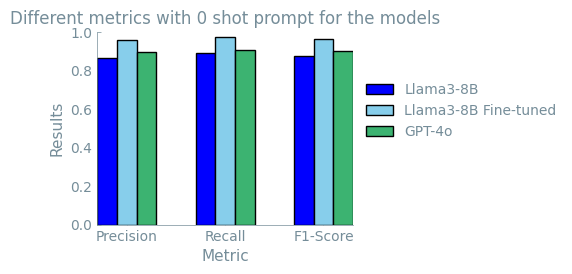

In [35]:
# Organize the results for easy plotting

models = ["llama", "sft", "openai"]
metrics = ["precision", "recall", "f1_scores"]

results = {}

results["llama_results"] = results_llama
results["openai_results"] = results_openai
results["sft_results"] = results_sft

metrics_0_shot = []
metrics_1_shot = []
for model in models:
    tmp_0 = []
    tmp_1 = []
    for metric in metrics:
        tmp_0.append(results[model + "_results"]["0-shot"][metric])
        tmp_1.append(results[model + "_results"]["1-shot"][metric])
    metrics_0_shot.append(tmp_0)
    metrics_1_shot.append(tmp_1)

# set width of bar
barWidth = 0.2
fig = plt.subplots()

plt_models = ["Llama3-8B", "Llama3-8B Fine-tuned", "GPT-4o"]
plt_metrics = ["Precision", "Recall", "F1-Score"]
plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_0_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_0_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_0_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_0_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_0_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric")
plt.ylabel(
    "Results",
)
plt.xticks([r + barWidth for r in range(len(metrics_0_shot[0]))], plt_metrics)
plt.ylim(0, 1)
plt.title("Different metrics with 0 shot prompt for the models")

plt.legend(bbox_to_anchor=(1, 0.8))
# plt.savefig("bars0.png")
plt.show()

For the 0-shot prompt is possible to see that the best results for all the metrics are the ones obtained when using the closed-source model that is presumably the bigger one of the three. The results to both Llama3-8B models are very similar. The fact that all the results are that similar between them is probably because of the evaluation used.

findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the followin

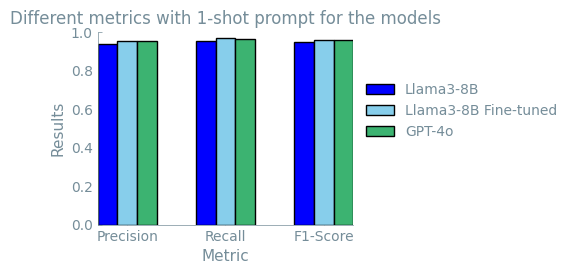

In [36]:
# set width of bar
barWidth = 0.2
fig = plt.subplots()

plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_1_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_1_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_1_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_1_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_1_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric")
plt.ylabel("Results")
plt.xticks([r + barWidth for r in range(len(metrics_1_shot[0]))], plt_metrics)
plt.ylim(0, 1)
plt.title("Different metrics with 1-shot prompt for the models")

plt.legend(bbox_to_anchor=(1, 0.8))
# plt.savefig("bars1.png")
plt.show()

When using the 1-shot prompt it is possible to see that the results are slightly better for the closed-source model.

Additionally, is possible to see that the fine-tuned model perform worse than the vanilla Llama3-8B model. As pointed above, this is because the fine-tuned model is seeing a format that is not the one that saw during training. Because of that, and having these results to prove it, we recommend avoiding the use of few-shot prompts with fine-tuned models.

findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: IBM Plex Sans, Roboto, Helvetica
findfont: Generic family 'sans-serif' not found because none of the followin

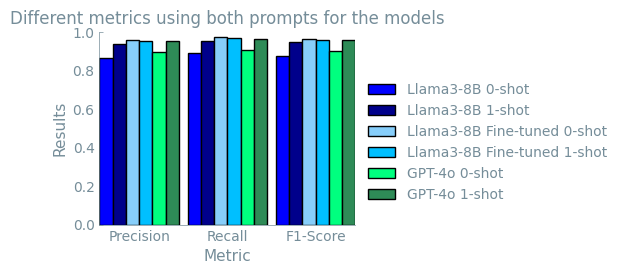

In [37]:
# Organize the results for easy plotting
results = {}

results["llama_results"] = results_llama
results["openai_results"] = results_openai
results["sft_results"] = results_sft

metrics_ = []

for model in models:
    tmp_0 = []
    tmp_1 = []
    for metric in metrics:
        tmp_0.append(results[model + "_results"]["0-shot"][metric])
        tmp_1.append(results[model + "_results"]["1-shot"][metric])
    metrics_.append(tmp_0)
    metrics_.append(tmp_1)

# set width of bar
barWidth = 0.15
fig = plt.subplots()

plt_models = [
    "Llama3-8B 0-shot",
    "Llama3-8B 1-shot",
    "Llama3-8B Fine-tuned 0-shot",
    "Llama3-8B Fine-tuned 1-shot",
    "GPT-4o 0-shot",
    "GPT-4o 1-shot",
]
plt_metrics = ["Precision", "Recall", "F1-Score"]
plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(
    br1,
    metrics_[0],
    color="blue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_[1],
    color="darkblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_[2],
    color="lightskyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)
plt.bar(
    br4,
    metrics_[3],
    color="deepskyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[3],
)
plt.bar(
    br5,
    metrics_[4],
    color="springgreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[4],
)
plt.bar(
    br6,
    metrics_[5],
    color="seagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[5],
)

# Adding Xticks
plt.xlabel("Metric")
plt.ylabel("Results")
plt.xticks([r + 2.5 * barWidth for r in range(len(metrics_[0]))], plt_metrics)
plt.ylim(0, 1)
plt.title("Different metrics using both prompts for the models")
plt.legend(bbox_to_anchor=(1, 0.8))

# plt.savefig("another.png")
plt.show()

When comparing all the results, it is evident that the 1-shot prompt yields better results for the three models compared to the 0-shot prompt.

Furthermore, it is worth noting that the closed-source model with the 1-shot prompt achieves the best overall result, with an F$_1$-score exceeding 0.95.

It is also important to highlight the underwhelming results of the fine-tuned model when using the 1-shot prompt. This is due to the fact that during the fine-tuning process, the model becomes highly adapted to a specific format, which is disrupted when using the 1-shot prompt. Typically, few-shot prompts are not used with the fine-tuned model for this reason.

Lastly, it is crucial to acknowledge that the small differences observed may be attributed to the evaluation method. The BERTScore method measures token-by-token similarity, which may not be very reliable when applied to a JSON schema containing numerous curly brackets and other schema-related tokens. For more reliable evaluations, please refer to the evaluations notebook[REF].

## References

```{bibliography}
:filter: docname in docnames
```